In [13]:
import torch #should be installed by default in any colab notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
import os


import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.functional as F
import numpy as np
import torch.optim as optim
import math

from typing import *
### Embeddings in 2 dimensions in order to plot them
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.numel()
    return np

In [14]:
# If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data

In [15]:
history = {}
input_size = (256,256)
data_dir = "../data/MIT_small_train_1/"


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

batch_size = 12

In [16]:
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}

## Models

In [6]:
class Fire(nn.Module):
    def __init__(self, inplanes: int, squeeze_planes: int, expand1x1_planes: int, expand3x3_planes: int) -> None:
        super().__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes, kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes, kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.squeeze_activation(self.squeeze(x))
        #print(x.shape, "enter to Fire")
        #print(self.expand1x1(x).shape, "after expanding 1x1")
        #print(self.expand3x3(x).shape, "after expanding 3x3")
        return torch.cat(
            [self.expand1x1_activation(self.expand1x1(x)), self.expand3x3_activation(self.expand3x3(x))], 1
        )


class MySqueezeNet(nn.Module):
    def __init__(self):
        super(MySqueezeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1) # 32
        self.bn1 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 16
        self.fire2 = Fire(128, 16, 64, 64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 8
        self.glob_avg_pool = nn.AdaptiveMaxPool2d(1)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.fire2(x)
        x = self.maxpool2(x)
        #x = self.fire3(x)
        x = self.glob_avg_pool(x)
        #print(x.shape)
        #.view(-1, 128)
        

        return x.view(-1, 128)


## Hyperparameters

In [6]:
torch.backends.cudnn.benchmark = True
learning_rate = 1e-3
lambda_l2 = 1e-5
momentum = 0.5
torch.manual_seed(0) # seed for reproductibility

model = MySqueezeNet()

print(f"Number of parameters {get_n_params(model)}:")

# move model to gpu if available
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

Number of parameters 16272:


## Defining the pretrain in order to intialize the embeddings in a proper way

In [11]:
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)        
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        
        optimizer.step()
        if batch_idx % 20 == 0:
            print(
                "Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(
                    epoch, batch_idx, loss, mining_func.num_triplets
                )
            )


### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, test_labels, train_embeddings, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))
    
    
def save_model(model_state_dict: object, path, filename:str) -> None:
    if not os.path.isdir(path):
        os.makedirs(path)
    torch.save(model_state_dict(), os.path.join(path, filename))


def write_pickle(information:Any,filepath:str):
    """
    Serialize and write an object to the specified file using pickle.

    Parameters:
        information (Any): The object to be serialized and written.
        filepath (str): The path to the file to write the pickled object.
    """

    abs_path = os.path.dirname(filepath)
    os.makedirs(abs_path, exist_ok=True)
    with open(filepath, "wb") as f:
        pickle.dump(information, f)


In [36]:
### pytorch-metric-learning stuff ###
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.1, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.1, type_of_triplets="hard"
)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###

In [37]:
for epoch in range(1, 10 + 1):
    train(model, loss_func, mining_func, device, dataloaders_dict["train"], optimizer, epoch)
    test(image_datasets["train"], image_datasets["test"], model, accuracy_calculator)

Epoch 1 Iteration 0: Loss = 0.1684197038412094, Number of mined triplets = 22
Epoch 1 Iteration 20: Loss = 0.16821159422397614, Number of mined triplets = 22


100%|███████████████████████████████████████████| 72/72 [00:05<00:00, 14.35it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.5568181818181818


Epoch 2 Iteration 0: Loss = 0.16586704552173615, Number of mined triplets = 25
Epoch 2 Iteration 20: Loss = 0.18203866481781006, Number of mined triplets = 19


100%|███████████████████████████████████████████| 72/72 [00:04<00:00, 14.47it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.5502622377622378


Epoch 3 Iteration 0: Loss = 0.11764924973249435, Number of mined triplets = 2
Epoch 3 Iteration 20: Loss = 0.11510289460420609, Number of mined triplets = 7


100%|███████████████████████████████████████████| 72/72 [00:04<00:00, 14.47it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.5681818181818182


Epoch 4 Iteration 0: Loss = 0.12889134883880615, Number of mined triplets = 16
Epoch 4 Iteration 20: Loss = 0.13714614510536194, Number of mined triplets = 24


100%|███████████████████████████████████████████| 72/72 [00:04<00:00, 14.51it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.5655594405594405


Epoch 5 Iteration 0: Loss = 0.14230972528457642, Number of mined triplets = 55
Epoch 5 Iteration 20: Loss = 0.153579980134964, Number of mined triplets = 18


100%|███████████████████████████████████████████| 72/72 [00:04<00:00, 14.51it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.5646853146853147


Epoch 6 Iteration 0: Loss = 0.12554559111595154, Number of mined triplets = 17
Epoch 6 Iteration 20: Loss = 0.11558430641889572, Number of mined triplets = 36


100%|███████████████████████████████████████████| 72/72 [00:04<00:00, 14.54it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.5458916083916084


Epoch 7 Iteration 0: Loss = 0.12132886797189713, Number of mined triplets = 14
Epoch 7 Iteration 20: Loss = 0.11112203449010849, Number of mined triplets = 7


100%|███████████████████████████████████████████| 72/72 [00:14<00:00,  4.97it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5476398601398601
Epoch 8 Iteration 0: Loss = 0.10989312082529068, Number of mined triplets = 22
Epoch 8 Iteration 20: Loss = 0.1064932644367218, Number of mined triplets = 7


100%|███████████████████████████████████████████| 72/72 [00:04<00:00, 14.48it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.5423951048951049


Epoch 9 Iteration 0: Loss = 0.11286932229995728, Number of mined triplets = 20
Epoch 9 Iteration 20: Loss = 0.11516505479812622, Number of mined triplets = 14


100%|███████████████████████████████████████████| 72/72 [00:05<00:00, 14.38it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.5506993006993007


Epoch 10 Iteration 0: Loss = 0.10947182029485703, Number of mined triplets = 7
Epoch 10 Iteration 20: Loss = 0.11012856662273407, Number of mined triplets = 31


100%|███████████████████████████████████████████| 72/72 [00:05<00:00, 14.23it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.5659965034965035


In [39]:
save_model(model.state_dict, filename="preetrain_triplet.pt", path="./checkpoints")

In [19]:
try:
    model.load_state_dict(torch.load("./checkpoints/preetrain_triplet.pt"))
    model.cuda()
except:
    for epoch in range(1, 10 + 1):
        train(model, loss_func, mining_func, device, dataloaders_dict["train"], optimizer, epoch)
        test(image_datasets["train"], image_datasets["test"], model, accuracy_calculator)


In [20]:
with torch.no_grad():
    # This is a faster way
    val_embeddings, val_labels = get_all_embeddings(image_datasets["train"], model)
    test_embeddings, test_labels = get_all_embeddings(image_datasets["test"], model)
    dist = torch.cdist(test_embeddings, val_embeddings)

100%|███████████████████████████████████████████| 72/72 [00:04<00:00, 14.57it/s]


In [21]:
train_dataset = image_datasets["train"]
test_dataset = image_datasets["test"]

In [22]:
train_dataset.loader
inverse_mapping = {j:i for i, j in train_dataset.class_to_idx.items()}

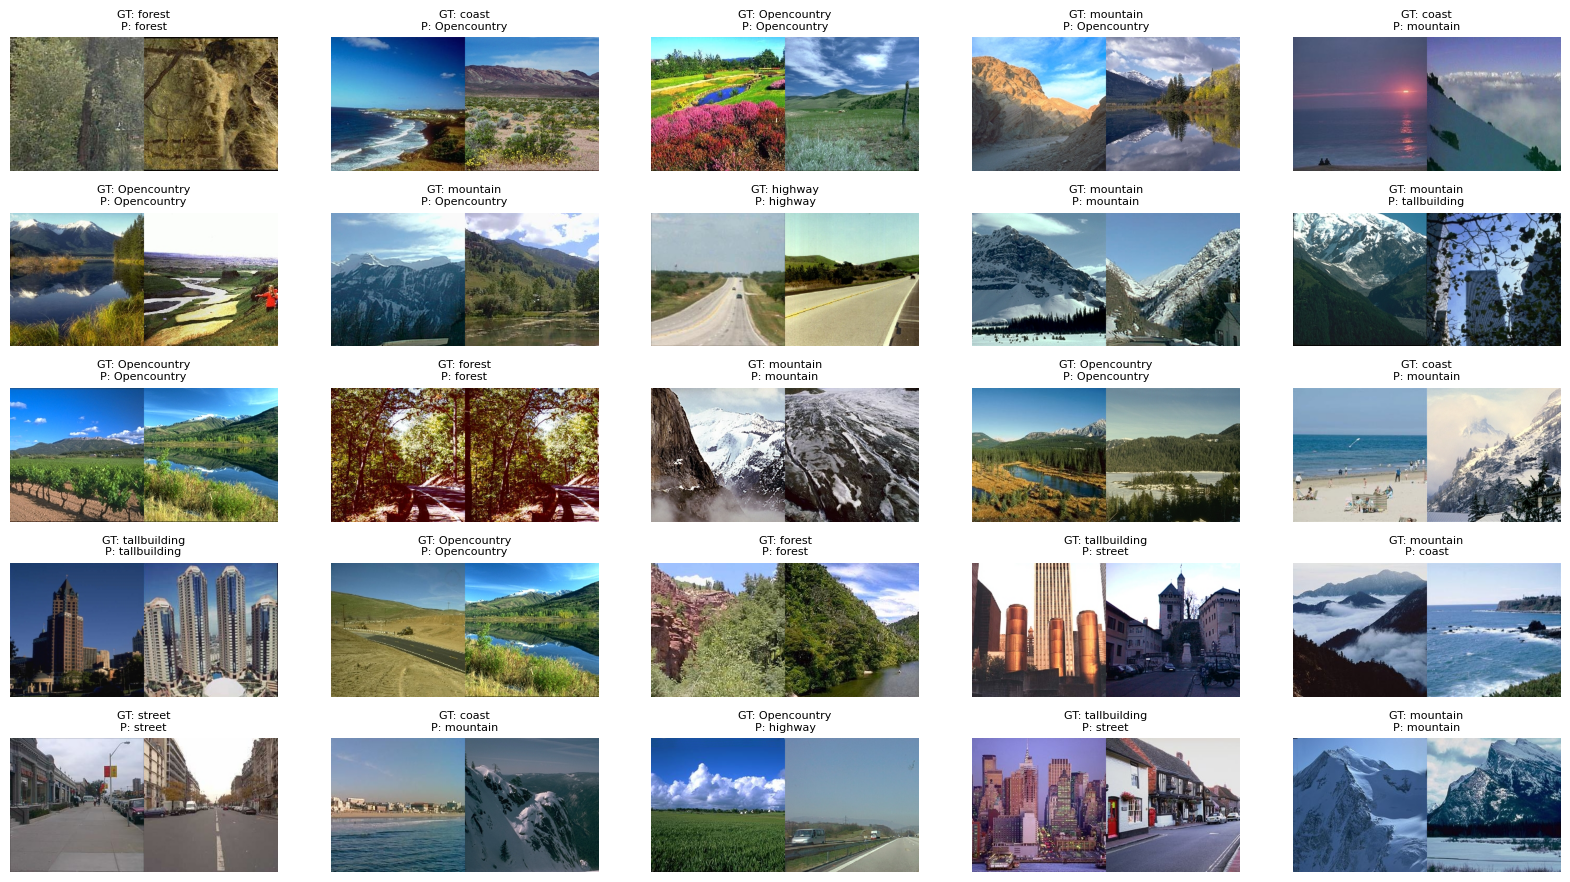

In [43]:
from PIL import Image
IMAGE_SIZE = 256
plt.figure(figsize = (20,11))
for i, idx in enumerate(np.random.choice(len(image_datasets["test"]), size=25, replace=False)):
    matched_idx = dist[idx].argmin().item()
    
    actual_label = test_dataset.imgs[idx][1]#.labels[idx]
    predicted_label = train_dataset.imgs[matched_idx][1]#.labels[matched_idx]
    
    actual_image_path = test_dataset.imgs[idx][0]#.images[idx]
    predicted_image_path = train_dataset.imgs[matched_idx][0]#.images[matched_idx]
    
    actual_image = np.array(Image.open(actual_image_path).resize((IMAGE_SIZE, IMAGE_SIZE)))
    predicted_image = np.array(Image.open(predicted_image_path).resize((IMAGE_SIZE, IMAGE_SIZE)))
    stack = np.hstack([actual_image, predicted_image])
    
    plt.subplot(5, 5, i+1)
    plt.imshow(stack)
    plt.title(f"GT: {inverse_mapping[actual_label]}\nP: {inverse_mapping[predicted_label]}", fontdict = {'fontsize' : 8})
    plt.axis("off")


## Validating the quality of the embeddings

In [23]:
X_train = val_embeddings.cpu().numpy()
hue_train = val_labels.cpu().numpy().squeeze()

X_test = test_embeddings.cpu().numpy()
hue_test = test_labels.cpu().numpy().squeeze()

In [24]:
whole_points = np.concatenate((X_train, X_test), axis=0)
whole_hue = np.concatenate((hue_train, hue_test), axis=0)
whole_labels = [inverse_mapping[i] for i in whole_hue]

In [25]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(whole_points)

In [26]:
df = pd.DataFrame()

df["x"] = embeddings_2d[:, 0]
df['y'] = embeddings_2d[:, 1]
df["true_labels"] = whole_labels
level = ["train" if _ < X_train.shape[0] else "test" for _ in range(len(whole_hue))]
df["level"] = level

In [70]:
df

,x,y,true_labels,level
0,-41.808048,-15.907073,Opencountry,train
1,-9.490268,-26.242310,Opencountry,train
2,-46.570984,0.393868,Opencountry,train
3,-47.326839,6.709625,Opencountry,train
4,-52.620968,6.128827,Opencountry,train
...,...,...,...,...
2683,14.682476,-9.165630,tallbuilding,test
2684,15.456071,-8.333791,tallbuilding,test
2685,26.454815,-11.672266,tallbuilding,test
2686,44.346848,-8.585606,tallbuilding,test


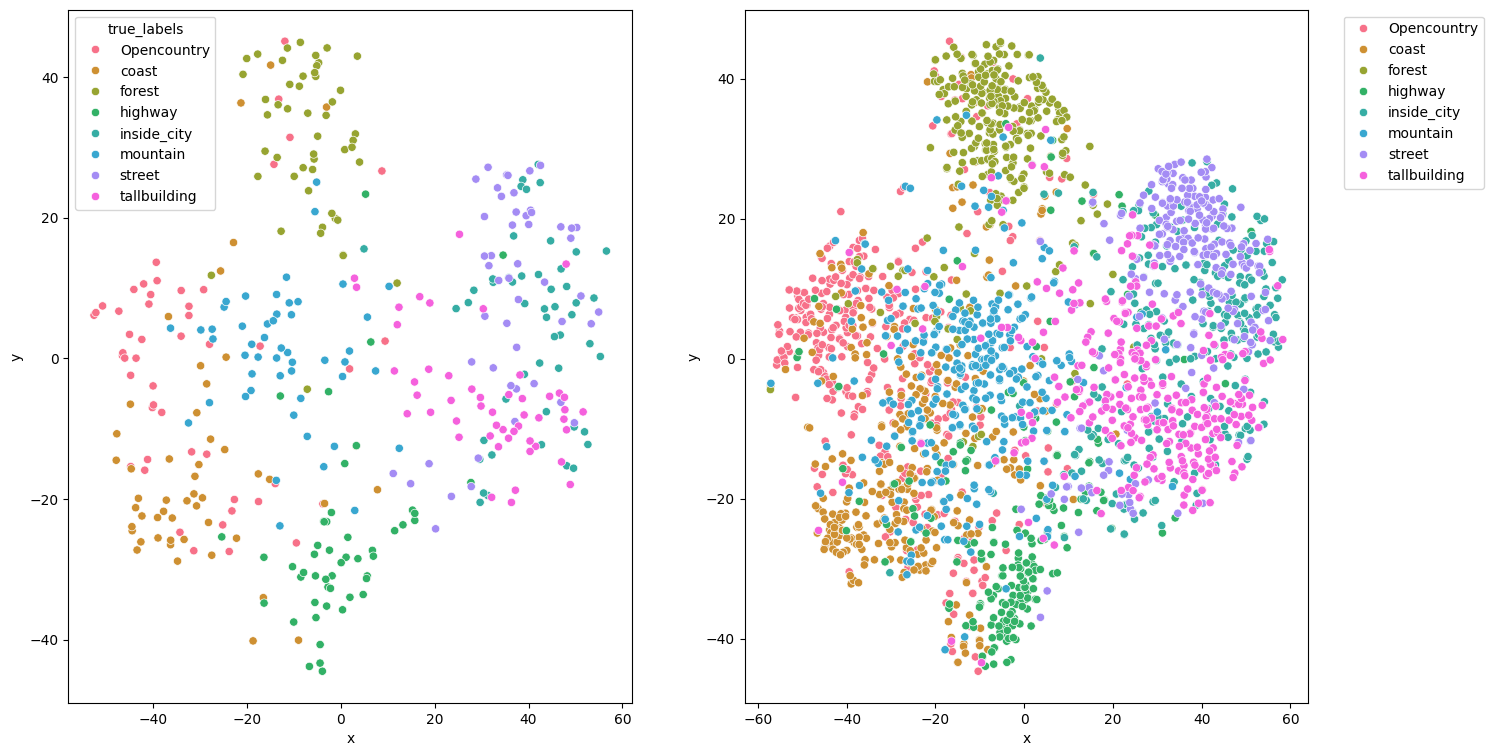

In [71]:
fig, axs = plt.subplots(ncols=2, figsize=(16,9))
classes = df["true_labels"].unique()
class_colors = sns.color_palette("husl", n_colors=len(classes))

# Mapear clases a colores
class_color_dict = dict(zip(classes, class_colors))




sns.scatterplot(data = df[df["level"]== "train"], x="x", y="y", hue = "true_labels", ax=axs[0], palette=class_color_dict)

sns.scatterplot(data = df[df["level"]== "test"], x="x", y="y", hue = "true_labels", ax=axs[1], palette=class_color_dict)
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Leyenda para el primer subgráfico

In [76]:
np.unique(hue_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([50, 50, 50, 50, 50, 50, 50, 50]))

## See if an SVM works

In [7]:
model = MySqueezeNet()

model.load_state_dict(torch.load("./checkpoints/preetrain_triplet.pt"))

<All keys matched successfully>

In [27]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
clf = SVC(probability=True)
clf.fit(X_train, hue_train)
predictions = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

In [28]:
from sklearn.model_selection import train_test_split, GridSearchCV


clf = SVC()
param_grid = {
    'C': [0.1, 1, 10],           
    'kernel': ['linear', 'rbf'],      
    'gamma': [0.01, 0.1, 1, 'auto'],
    "probability": [True]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

grid_search.fit(X_train, hue_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'C': 10, 'gamma': 1, 'kernel': 'rbf', 'probability': True}


In [29]:
grid_search.best_score_

0.7325

In [30]:
acc_test = accuracy_score(grid_search.predict(X_test), hue_test)
predictions = grid_search.predict(X_test)
y_test= hue_test

In [31]:
predictions.reshape(-1, 1).shape, y_test.reshape(-1,1).shape


((2288, 1), (2288, 1))

In [32]:
precision_score(predictions.reshape(-1, 1), y_test.reshape(-1, 1), average="macro")

0.6252242324802587

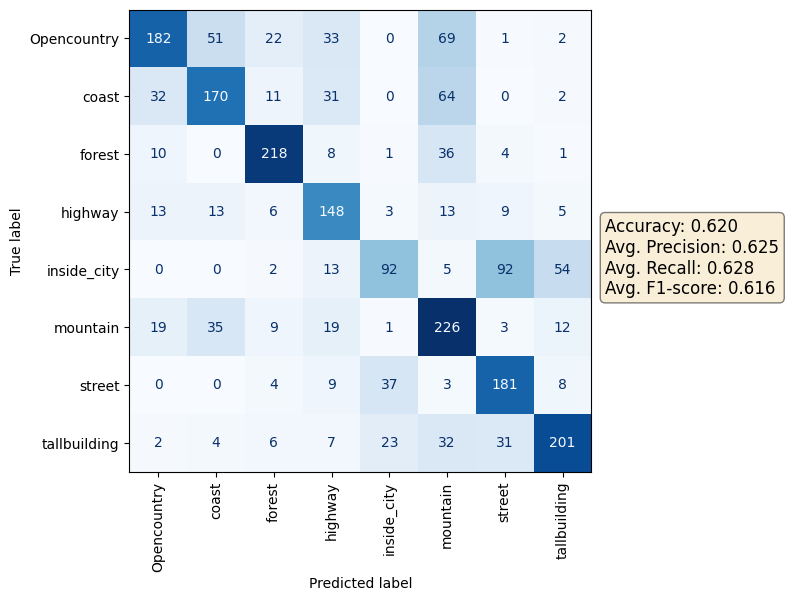

In [34]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(df["true_labels"].unique()))
_, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical', colorbar=False)

# Adding text for metrics
textstr = '\n'.join((
    f'Accuracy: {acc_test:.3f}',
    f'Avg. Precision: {precision_score(predictions.reshape(-1, 1), y_test.reshape(-1, 1), average="macro"):.3f}',
    f'Avg. Recall: {recall_score(predictions.reshape(-1, 1), y_test.reshape(-1, 1), average="macro"):.3f}',
    f'Avg. F1-score: {f1_score(predictions.reshape(-1, 1), y_test.reshape(-1, 1), average="macro"):.3f}'))

# These are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# Place a text box in upper left in axes coords
ax.text(1.03, 0.55, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.show()

In [35]:
y_score = grid_search.predict_proba(X_test)


[0 1 2 3 4 5 6 7]


Text(0.5, 1.0, 'Micro-averaged Precision-Recall curve')

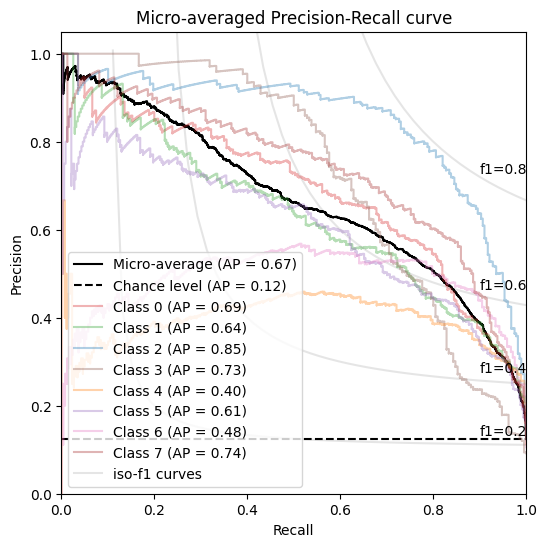

In [36]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay

colors = ["tab:red", "tab:green", "tab:blue", "tab:brown", "tab:orange", "tab:purple", "tab:pink", "brown"]
enc = LabelBinarizer()


y_onehot_test = OneHotEncoder(handle_unknown='ignore').fit_transform(np.array(hue_test.reshape(-1, 1))).toarray()
clas = (np.unique(hue_test))
n_classes = y_onehot_test.shape[1]
print(clas)

# For each class
precision_dict  = dict()
recall_dict  = dict()
average_precision_dict = dict()
for i in range(n_classes):
    precision_dict[i], recall_dict[i], _ = precision_recall_curve(y_onehot_test[:, i], y_score[:, i])
    average_precision_dict[i] = average_precision_score(y_onehot_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision_dict["micro"], recall_dict["micro"], _ = precision_recall_curve(
    y_onehot_test.ravel(), y_score.ravel()
)
average_precision_dict["micro"] = average_precision_score(y_onehot_test, y_score, average="micro")


from collections import Counter

_, ax = plt.subplots(figsize=(6, 6))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall_dict["micro"],
    precision=precision_dict["micro"],
    average_precision=average_precision_dict["micro"],
    prevalence_pos_label=Counter(y_onehot_test.ravel())[1] / y_onehot_test.size,
)
display.plot(ax=ax, name="Micro-average", plot_chance_level=True, color='black')


for i, (cl, color) in enumerate(zip(clas, colors)):
    display = PrecisionRecallDisplay(
        recall=recall_dict[i],
        precision=precision_dict[i],
        average_precision=average_precision_dict[i],
    )
    display.plot(ax=ax, name=f"Class {i}", color=color, alpha=0.35)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Micro-averaged Precision-Recall curve")

## Training the embeddings with an MLP

In [43]:
# Training loop
def train(epoch, criterion, model, model_pretrain, optimizer, loader):
    
    total_loss = 0.0

    model.train()

    for batch_idx, (data, target) in enumerate(loader):
        
        optimizer.zero_grad()

        data, target = data.to(device), target.to(device)
        
        pretrained_embeddings = model_pretrain(data)
        
        output = model(pretrained_embeddings)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item()))


        total_loss += loss.item()  #.item() is very important here? Why?

    return total_loss / len(loader.dataset)

@torch.no_grad()  # prevent this function from computing gradients 
def validate(criterion, model, model_pretrain, loader):

    val_loss = 0
    correct = 0

    model.eval()
    model_pretrain.eval()

    for data, target in loader:

        data, target = data.to(device), target.to(device)

        pretrain_embeddings = model_pretrain(data)
        output = model(pretrain_embeddings)
        loss = criterion(output, target)
        val_loss += loss.item()                                                              
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset), accuracy))


    return val_loss

class MoreComplexMLP(nn.Module):

    def __init__(self, inDim, outDim):
        super().__init__()
        self.fc1 = nn.Linear(inDim, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, outDim)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out
    
modelComplex = MoreComplexMLP(128, 8)

In [38]:
learning_rate = 1e-1
lambda_l2 = 1e-5
optimizer = torch.optim.Adam(modelComplex.parameters(), lr=learning_rate, weight_decay=lambda_l2)
criterion = torch.nn.CrossEntropyLoss()
modelComplex.to(device)
model.cuda()

MySqueezeNet(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fire2): Fire(
    (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (glob_avg_pool): AdaptiveMaxPool2d(output_size=1)
)

In [39]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [40]:
input_size = (256,256)
data_dir = "../data/MIT_small_train_1/"


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

batch_size = 28
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}


In [ ]:
losses = {"train": [], "val": []}
for epoch in range(10):

    train_loss = train(loader=dataloaders_dict["train"], criterion=criterion, model_pretrain=model, model=modelComplex, optimizer=optimizer, epoch=epoch)
    #val_loss = validate(criterion, model_pretrain=model, model=modelComplex, loader=dataloaders_dict["test"])
    losses["train"].append(train_loss)
    #losses["val"].append(val_loss)

